In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import auc, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss
from nltk.corpus import stopwords
from datetime import datetime
from scipy import sparse
import seaborn as sns
import pandas as pd
import numpy as np
import _pickle as cPickle
import emoji
import nltk
import re

import matplotlib.pyplot as mp

import warnings
warnings.filterwarnings("ignore")

from anomalyFunctions import *

def correctDate(text):
    date = text.split()
    result = datetime.strptime(date[1]+date[2]+date[-1],"%b%d%Y").strftime("%s")
    return result

#-----Read comments data-----#
name = 'mcdonalds'
nrow = 3000

comments_dir = '/Users/degravek/DataScience/SafeSocial/data/' + name + '/'
imposter_dir = '/Users/degravek/DataScience/SafeSocial/data/'

comments = pd.read_csv(comments_dir + name + '.csv', usecols=['text','created_at'])
comments['created_at'] = comments['created_at'].apply(correctDate)
comments.sort_values('created_at', ascending=False)

comments = comments[:nrow][['text']]

#-----Read imposter data-----#
imposter = pd.read_csv(imposter_dir + 'corporate_dataset.csv', usecols=['text'])

#-----Combine datasets-----#
comments.drop_duplicates('text', inplace=True)
imposter.drop_duplicates('text', inplace=True)

imposter = imposter.sample(n=comments.shape[0], replace=False, random_state=0)
imposter['target'] = 1
comments['target'] = 0

df = comments.append(imposter)
df.reset_index(drop=True, inplace=True)

In [2]:
df['numHash']  = df['text'].apply(numHash)
df['numEmoji'] = df['text'].apply(numEmoji)
df['ratioPunc'] = df['text'].apply(ratioPunc)
df['ratioCaps'] = df['text'].apply(ratioCaps)
df['textPro'] = df['text'].apply(processTextAnomaly)

df = df[df['textPro'] != '']

df['avgWordLen']  = df['text'].apply(avgWordLen)
df['partSpeech']  = df['textPro'].apply(partSpeech)
df['ratioStop']   = df['textPro'].apply(ratioStop)
df['ratioAtuser'] = df['textPro'].apply(ratioAtuser)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

y_train = df_train['target'].values
y_test = df_test['target'].values

df_train.drop('target', axis=1, inplace=True)
df_train.reset_index(drop=True, inplace=True)

df_test.drop('target', axis=1, inplace=True)
df_test.reset_index(drop=True, inplace=True)

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [41]:
param_grid = [{'tvec__ngram_range': [(1,1), (3,3), (1,3)],
                'tvec__stop_words': ['english', None],
                'tvec__max_features': [500, None],
                'tvec__use_idf': [True, False],
                'tvec__analyzer': ['word', 'char'],
                'clf__penalty': ['l1', 'l2']}]

tvec = TfidfVectorizer(strip_accents='unicode', norm=None)

pipeline = Pipeline([('DCE1', ItemSelector('textPro')), ('tvec', tvec),
                    ('clf', LogisticRegression())])

grid_cv = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5, verbose=5)
grid_cv.fit(df_train, y_train)

print(grid_cv.best_params_)
print(grid_cv.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True, score=0.8678646934460887, total=   0.1s
[CV] clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True, score=0.8932346723044398, total=   0.1s
[CV] clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True, score=0.8603174603174604, total=   0.1s
[CV] clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True, score=0.8603174603174604, total=   0.1s
[CV] clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True, score=0.8697033898305084, total=   0.1s
[CV] clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False, score=0.8752642706131079, total=   0.1s
[CV] clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l1, tvec__analyzer=wo

[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=False, score=0.6133474576271186, total=   0.2s
[CV] clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True, score=0.6363636363636364, total=   0.2s
[CV] clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True, score=0.6331923890063424, total=   0.2s
[CV] clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_fea

[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=False, score=0.8393234672304439, total=   0.5s
[CV] clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=False 
[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=False, score=0.8530655391120507, total=   0.5s
[CV] clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=False 
[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=False, score=0.855026455026455, total=   0.5s
[CV] clf__penalty=l1, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=False 
[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_fe

[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=True, score=0.6194503171247357, total=   0.3s
[CV] clf__penalty=l1, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=True, score=0.6158730158730159, total=   0.2s
[CV] clf__penalty=l1, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=True, score=0.638095238095238, total=   0.2s
[CV] clf__penalty=l1, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l1, tvec__analyzer=

[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=english, tvec__use_idf=False, score=0.8804232804232804, total=   0.4s
[CV] clf__penalty=l1, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=english, tvec__use_idf=False, score=0.8878306878306879, total=   0.4s
[CV] clf__penalty=l1, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l1, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=english, tvec__use_idf=False, score=0.8961864406779662, total=   0.4s
[CV] clf__penalty=l1, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l1, tvec__analyz

[CV]  clf__penalty=l1, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=None, tvec__use_idf=True, score=0.7142857142857143, total=   0.2s
[CV] clf__penalty=l1, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l1, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=None, tvec__use_idf=True, score=0.6758474576271186, total=   0.2s
[CV] clf__penalty=l1, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=None, tvec__use_idf=False 
[CV]  clf__penalty=l1, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=None, tvec__use_idf=False, score=0.6797040169133193, total=   0.3s
[CV] clf__penalty=l1, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=None, tvec__use_idf=False 
[CV]  clf__penalty=l1, tvec__analyzer=char, tvec__max_feat

[CV]  clf__penalty=l1, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=False, score=0.8463983050847458, total=   0.6s
[CV] clf__penalty=l1, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 3), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l1, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 3), tvec__stop_words=english, tvec__use_idf=True, score=0.8446088794926004, total=   4.6s
[CV] clf__penalty=l1, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 3), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l1, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 3), tvec__stop_words=english, tvec__use_idf=True, score=0.8382663847780126, total=   2.8s
[CV] clf__penalty=l1, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 3), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l1, tvec__analyzer=char, t

[CV]  clf__penalty=l1, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False, score=0.6797040169133193, total=   0.3s
[CV] clf__penalty=l1, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l1, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False, score=0.6754756871035941, total=   0.3s
[CV] clf__penalty=l1, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l1, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False, score=0.6931216931216931, total=   0.2s
[CV] clf__penalty=l1, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l1, tvec__an

[CV]  clf__penalty=l1, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True, score=0.8879492600422833, total=   0.5s
[CV] clf__penalty=l1, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l1, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True, score=0.8984126984126984, total=   0.4s
[CV] clf__penalty=l1, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l1, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True, score=0.8899470899470899, total=   0.5s
[CV] clf__penalty=l1, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l1, tvec__analyzer=char, tvec__max_f

[CV]  clf__penalty=l1, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=False, score=0.8878306878306879, total=   3.6s
[CV] clf__penalty=l1, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=False 
[CV]  clf__penalty=l1, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=False, score=0.8931216931216931, total=   2.4s
[CV] clf__penalty=l1, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=False 
[CV]  clf__penalty=l1, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=False, score=0.875, total=   2.7s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_feature

[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=True, score=0.6201058201058202, total=   0.2s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=True, score=0.6228813559322034, total=   0.2s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=False, score=0.6300211416490487, total=   0.2s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=wo

[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 3), tvec__stop_words=english, tvec__use_idf=False, score=0.871822033898305, total=   0.3s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=True, score=0.8234672304439746, total=   0.5s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=True, score=0.8308668076109936, total=   0.5s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_feat

[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=None, tvec__use_idf=False, score=0.9016913319238901, total=   0.1s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=None, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=None, tvec__use_idf=False, score=0.8835978835978836, total=   0.1s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=None, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=None, tvec__use_idf=False, score=0.8857142857142857, total=   0.1s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=None, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec_

[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=english, tvec__use_idf=True, score=0.8846560846560847, total=   0.4s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=english, tvec__use_idf=True, score=0.9111111111111111, total=   0.5s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=english, tvec__use_idf=True, score=0.9258474576271186, total=   0.4s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyze

[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False, score=0.7132275132275132, total=   0.2s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False, score=0.673728813559322, total=   0.2s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=None, tvec__use_idf=True, score=0.6797040169133193, total=   0.2s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__

[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True, score=0.8326271186440678, total=   0.5s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=False, score=0.8530655391120507, total=   0.7s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=False, score=0.8520084566596194, total=   0.5s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_fe

[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True, score=0.6797040169133193, total=   0.2s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True, score=0.6754756871035941, total=   0.2s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True, score=0.6973544973544974, total=   0.3s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer

[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=False, score=0.8953488372093024, total=   0.5s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=False, score=0.9153439153439153, total=   0.5s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=False, score=0.9037037037037037, total=   0.5s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__an

[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=True, score=0.9026455026455027, total=   1.5s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=True, score=0.9026455026455027, total=   2.0s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=True, score=0.888771186440678, total=   1.9s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 3), tvec__stop_words=None, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_f

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  7.2min finished


{'clf__penalty': 'l2', 'tvec__analyzer': 'word', 'tvec__max_features': None, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': 'english', 'tvec__use_idf': True}
0.90816758358


In [42]:
tvec = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3),
                       max_features=None, norm=None, stop_words='english', use_idf=True)

X_train = tvec.fit_transform(df_train['textPro'])
X_test = tvec.transform(df_test['textPro'])

param_grid = [{'alpha': 10**np.linspace(-6, -1, 20)}]
grid_cv = GridSearchCV(SGDClassifier(loss='log', penalty='l2', max_iter=1000),
                                    param_grid, scoring='neg_log_loss', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)
print(grid_cv.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.3min finished


{'alpha': 0.00078475997035146064}
-0.226013951017


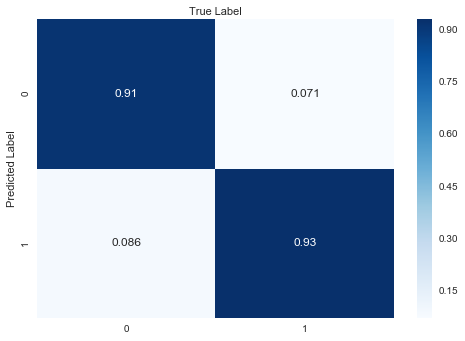

In [43]:
predict = grid_cv.predict(X_test)

cm = confusion_matrix(y_test, predict).T
cm = cm.astype('float')/cm.sum(axis=0)

fig, ax = mp.subplots()
sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.xaxis.set_label_position('top')
mp.show()

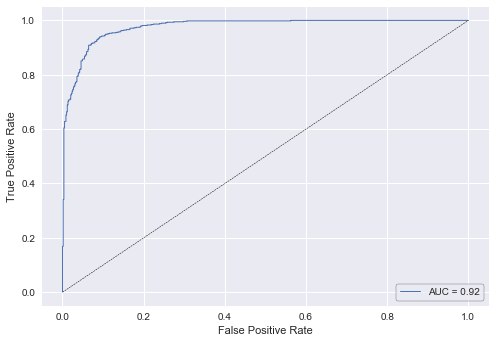

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, grid_cv.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, predict)

mp.plot(fpr, tpr, lw=1, label='AUC = %0.2f'%(roc_auc))
mp.plot([0, 1], [0, 1], '--k', lw=0.5)
mp.xlabel('False Positive Rate')
mp.ylabel('True Positive Rate')
mp.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')
mp.show()

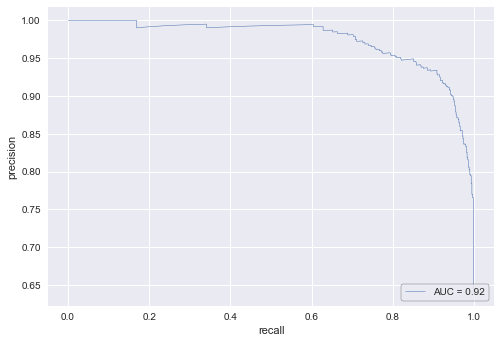

In [45]:
precision, recall, thresholds = precision_recall_curve(y_test, grid_cv.predict_proba(X_test)[:,1])

auc(recall, precision)

mp.plot(recall, precision, lw=0.5, label='AUC = %0.2f'%(roc_auc))
mp.xlabel('recall')
mp.ylabel('precision')
mp.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')
mp.show()

In [9]:
tvec

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm=None, preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [4]:
model = SGDClassifier(alpha=0.00078475997035146064, loss='log', penalty='l2', max_iter=1000)
model.fit(X_train, y_train)

SGDClassifier(alpha=0.0007847599703514606, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [5]:
dest = '/Users/degravek/DataScience/SafeSocial/application/pkl_objects_8172017/mcdonalds/'

cPickle.dump(model, open(os.path.join(dest, 'model_anomaly.pkl'), 'wb'), protocol=None)
cPickle.dump(tvec, open(os.path.join(dest, 'tvec_anomaly.pkl'), 'wb'), protocol=None)

In [49]:
text = "Bringing you more seatback entertainment than any other airline."

dnew = pd.DataFrame([text], columns=['text'])
dnew['numHash']  = dnew['text'].apply(numHash)
dnew['numEmoji'] = dnew['text'].apply(numEmoji)
dnew['ratioPunc'] = dnew['text'].apply(ratioPunc)
dnew['ratioCaps'] = dnew['text'].apply(ratioCaps)
dnew['textPro'] = dnew['text'].apply(processTextAnomaly)

dnew = dnew[dnew['textPro'] != '']

dnew['avgWordLen']  = dnew['text'].apply(avgWordLen)
dnew['partSpeech']  = dnew['textPro'].apply(partSpeech)
dnew['ratioStop']   = dnew['textPro'].apply(ratioStop)
dnew['ratioAtuser'] = dnew['textPro'].apply(ratioAtuser)

X_train = tvec.transform(dnew['textPro'])

print(grid_cv.predict_proba(X_train))

[[ 0.5058833  0.4941167]]
